# Neural Networks

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os

# Food recognition
import PIL
from os import listdir
from matplotlib import image
from matplotlib import pyplot
from PIL import Image
import pandas as pd


2002 training labels loaded
Start loading 200 images
Loading at 0.0%
Loading at 50.0%
Loading at 100.0%
Reached MAX_IMAGE count of 200
5
train_15.jpg


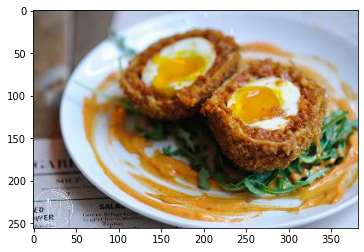

3
train_28.jpg


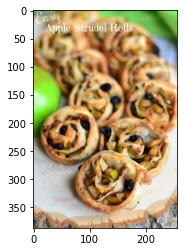

3
train_32.jpg


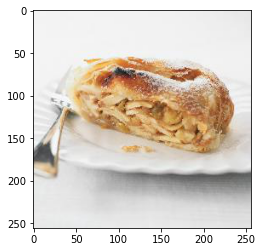

2
train_63.jpg


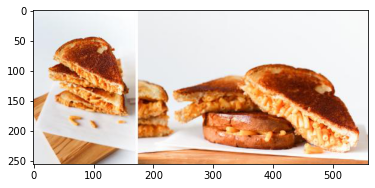

1
train_74.jpg


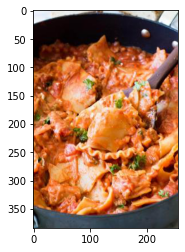

5
train_105.jpg


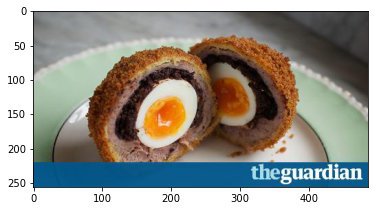

4
train_115.jpg


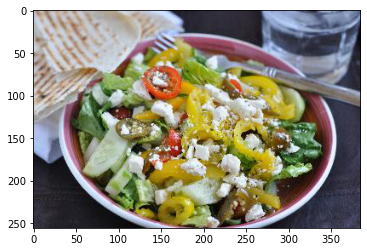

1
train_134.jpg


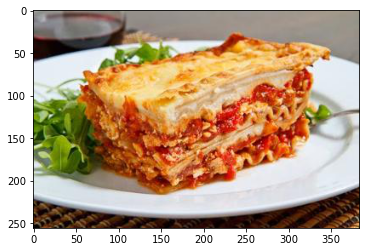

2
train_164.jpg


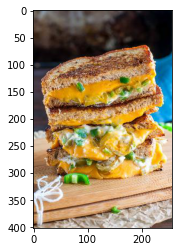

4
train_189.jpg


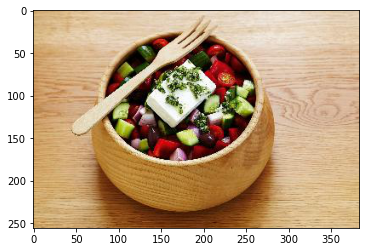

In [2]:
# Local data directories
DATA_DIR = '/Users/dj/Documents/GitHub/Data/food-recognition-challenge-2021'
TRAIN_DIR = DATA_DIR + '/train_set/train_set/'
TEST_DIR = DATA_DIR + '/test_set/test_set/'

# Maximum number of images to load (there are 30k)
MAX_IMAGE = 200

# Filter for a subset of labels in the images to load
FILTER_LABEL = ['1', '2', '3', '4', '5']

# load all the training labels
train_labels = pd.read_csv(DATA_DIR + '/train_labels.csv', dtype={'label': object})
if (len(FILTER_LABEL) > 0):
    train_labels = train_labels[train_labels['label'].isin(FILTER_LABEL)].copy().reset_index()
print('{} training labels loaded'.format(len(train_labels)))  

# load all the training images
train_images = list()
imcount = 0
if MAX_IMAGE == 0:
    MAX_IMAGE = len(train_labels)

print('Start loading {} images'.format(MAX_IMAGE))
for filename in train_labels['img_name']:
    # Load image
    img = Image.open(TRAIN_DIR + filename)
    
    # Resize image to the same shape
    # TODO: Don't squash all images into the same size
    #img = img.resize((256,256), Image.ANTIALIAS)

    # Convert image to numpy array
    img_data = np.array(img)

    # Store loaded image
    train_images.append(img_data)

    # Show progress
    if imcount % 100 == 0:
        print('Loading at {:.1f}%'.format(imcount/min(len(train_labels), MAX_IMAGE)*100))

    # Stop after X images   
    imcount += 1
    if imcount > MAX_IMAGE:
        print('Reached MAX_IMAGE count of '+str(MAX_IMAGE))
        break

# Show 10 samples
for i in range(0,min(10, len(train_labels))):
    print(train_labels['label'][i])
    print(train_labels['img_name'][i])
    pyplot.imshow(train_images[i])
    pyplot.show()

In [3]:
train_images[3].shape

(256, 559, 3)

# Model

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np

from keras.preprocessing.image import ImageDataGenerator

# Create a training and test set generator
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_split = int(len(train_labels)*0.8)
train_dataframe = train_labels[:train_split][['img_name','label']]
val_dataframe = train_labels[train_split:][['img_name','label']]

train_generator = train_datagen.flow_from_dataframe(
    train_dataframe,
    x_col = 'img_name',
    y_col = 'label',
    directory=TRAIN_DIR,
    target_size=(255,255),
    batch_size=20,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    val_dataframe,
    x_col = 'img_name',
    y_col = 'label',
    directory=TRAIN_DIR,
    target_size=(255,255),
    batch_size=20,
    class_mode='categorical'
)

Found 1601 validated image filenames belonging to 5 classes.
Found 401 validated image filenames belonging to 5 classes.


# Import Base Model

In [10]:
from keras.applications import ResNet50

base_model = ResNet50(input_shape=(255, 255,3), include_top=False, weights="imagenet")

In [11]:
for layer in base_model.layers:
    layer.trainable = False

In [12]:
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Flatten, GlobalAveragePooling2D

base_model = Sequential()
base_model.add(ResNet50(include_top=False, weights='imagenet', pooling='max'))
base_model.add(Dense(5, activation='softmax'))

base_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 23,544,837
Non-trainable params: 53,120
_________________________________________________________________


In [13]:
base_model.compile(optimizer='Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [14]:
history = base_model.fit(train_generator, steps_per_epoch=5, epochs = 10, validation_data = val_generator, validation_steps=5)

Epoch 1/10
5/5 [==============================] - 207s 41s/step - loss: 9.2125 - accuracy: 0.3800 - val_loss: 14.0689 - val_accuracy: 0.2400
Epoch 2/10
5/5 [==============================] - 169s 34s/step - loss: 4.4868 - accuracy: 0.6000 - val_loss: 54.3602 - val_accuracy: 0.2200
Epoch 3/10
5/5 [==============================] - 167s 33s/step - loss: 4.3097 - accuracy: 0.6600 - val_loss: 46.3792 - val_accuracy: 0.1400
Epoch 4/10
5/5 [==============================] - 166s 33s/step - loss: 11.3978 - accuracy: 0.4100 - val_loss: 27.4542 - val_accuracy: 0.2300
Epoch 5/10
5/5 [==============================] - 155s 31s/step - loss: 8.9241 - accuracy: 0.4700 - val_loss: 28.5988 - val_accuracy: 0.1975
Epoch 6/10
5/5 [==============================] - 166s 33s/step - loss: 5.4244 - accuracy: 0.5700 - val_loss: 21.7406 - val_accuracy: 0.1700
Epoch 7/10
5/5 [==============================] - 166s 33s/step - loss: 5.8911 - accuracy: 0.6100 - val_loss: 16.6855 - val_accuracy: 0.2400
Epoch 8/10
5

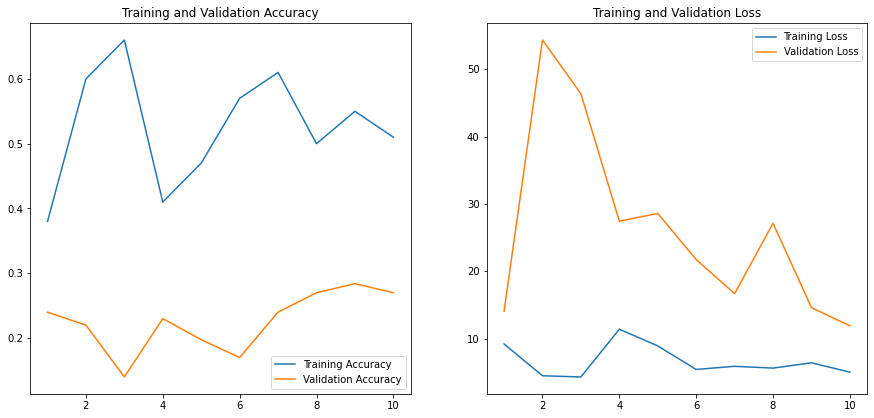

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Running time was 29 min